In [5]:
import simulation2 as sim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib import cm
from tqdm import tqdm
import scipy.stats as stats
import statsmodels.api as sm

In [6]:
# constantes pour pouvoir comparer
# statistiques de Lise
# sumstats de alliim-mini-main ?

## Functions

In [7]:
## as soon as I get a chaotic plot ==> distribution of the fractal dimension

def MSD(traj: np.array)-> np.array:
    """
    Allows to compute the Mean Squared Displacement of the trajectories for all timestamps
    
    Args:
    -----
    - `traj`: np.array of N trajectories of length T [NxT]
    
    Output:
    -------
    Mean Squared Displacement for all timestamps
    """
    
    if traj.ndim == 2:
        inds = np.arange(traj.shape[0])
        return np.sum((traj[inds,:] - traj[0, :])**2, axis = -1)
        
    else:
        inds = np.arange(traj.shape[0])
        return np.sum((traj[inds, :, :] - traj[0, :, :])**2, axis = -1)
    

def getDistance(traj: np.array):
    """
    Gets the squared distances from the trajectory
    
    Args:
    -----
    - `traj`: np.array of N trajectories of length T [NxT]
    
    Output:
    -------
    np.array with the distances or corresponding float if only 1 trajecotry
    """
    
    if traj.ndim == 2:
        inds = np.arange(1,traj.shape[0])
        dist = (traj[inds, :] - traj[inds-1, :])**2
        
        return np.sum(dist, axis = -1)

    else:
        inds = np.arange(1,traj.shape[0])
        dist = (traj[inds, :, :] - traj[inds-1, :, :])**2
        
        return np.sum(dist, axis = -1)

### Application

In [47]:
v0 = 50 # Active force
k = 10.  # Stiffness of interaction
boundary = 20
n = 500
# Assume 0 for now
epsilon = 500.  # Attractive component of interaction
tau = 40.0
params = v0, tau, k, epsilon
output, interactions = sim.compute_main(n, params, boundary)

v0:50, tau:40.0, k:10.0, epsilon:500.0


100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


In [48]:
print(output.shape)

(100, 500, 2)


In [49]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

In [50]:
def simpleDer(vect):
    inds = np.arange(vect.shape[0] - 1)
    inds2 = inds + 1

    v2 = vect[inds2, :, :] - vect[inds, :, :]

    return v2

speed = simpleDer(vect=output)

In [51]:
speedNorm = np.linalg.norm(speed, axis = -1)
tans = speed[:,:, 1]/speed[:,:, 0]
angleSpeed = np.arctan(tans)

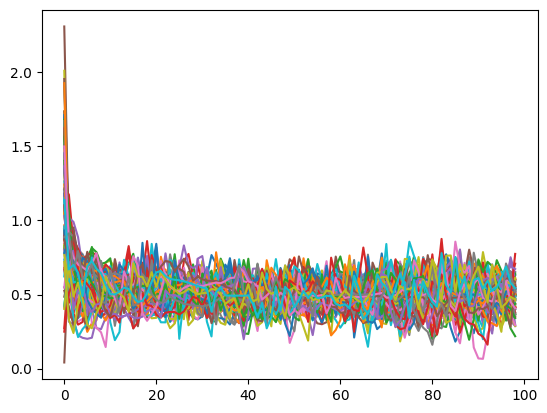

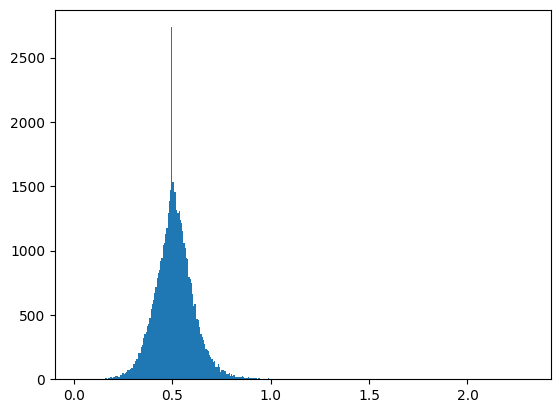

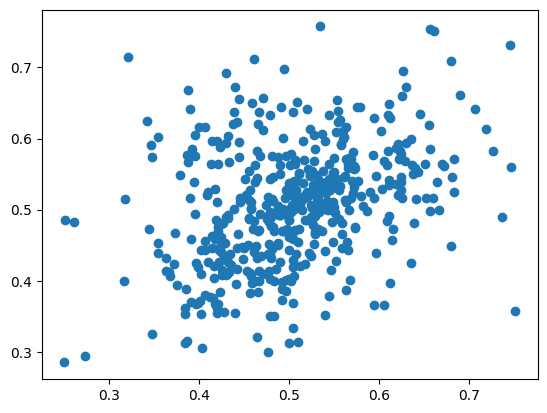

In [52]:
for i in range(100):
    plt.plot(speedNorm[:, i])

plt.show()

plt.hist(speedNorm.reshape(-1), bins = 'auto')
plt.show()

ind = 50
plt.scatter(speedNorm[ind, :], speedNorm[ind+1, :])
plt.show()

[[1.         0.36020756]
 [0.36020756 1.        ]]


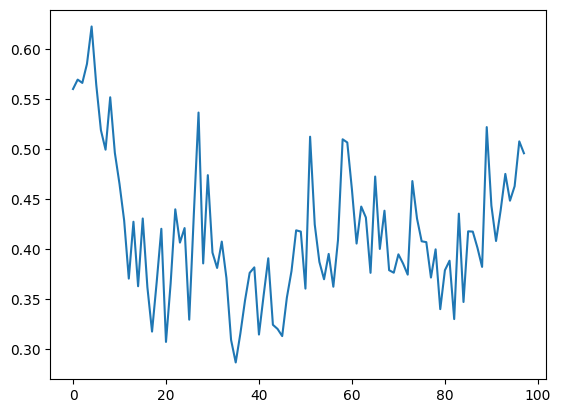

In [53]:
print(np.corrcoef(speedNorm[ind, :], speedNorm[ind+1, :]))


corSpeed = []

for i in range(speedNorm.shape[0]-1):
    corSpeed.append(np.corrcoef(speedNorm[i, :], speedNorm[i+1, :])[0, 1])

plt.plot(corSpeed)
plt.show()

In [54]:
print(output.shape)

(100, 500, 2)


(100, 500)


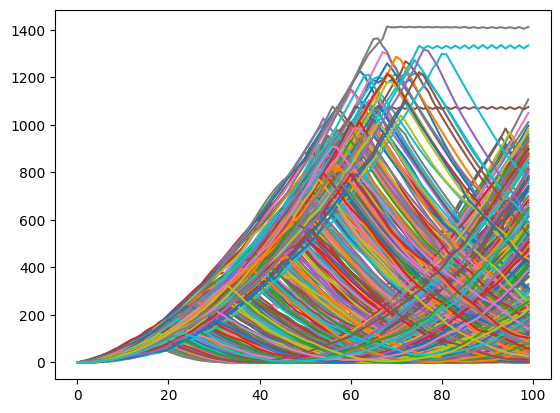

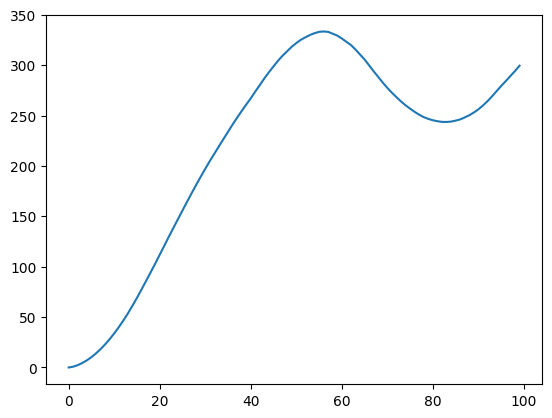

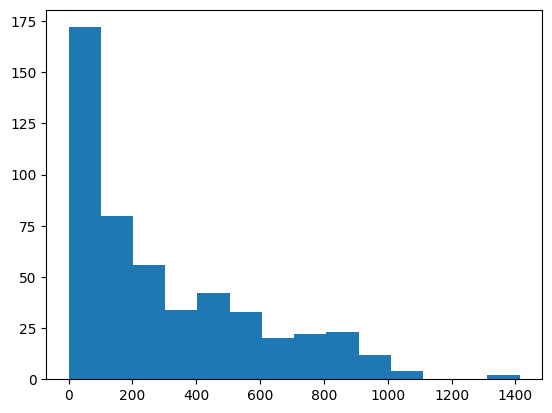

In [55]:
MSDvect = MSD(output[:, :, :])
print(MSDvect.shape)
plt.plot(MSDvect)
plt.show()

plt.plot(np.mean(MSDvect, axis = -1))
plt.show()

plt.hist(MSDvect[-1, :], bins = 'auto')
plt.show()

(99, 500)


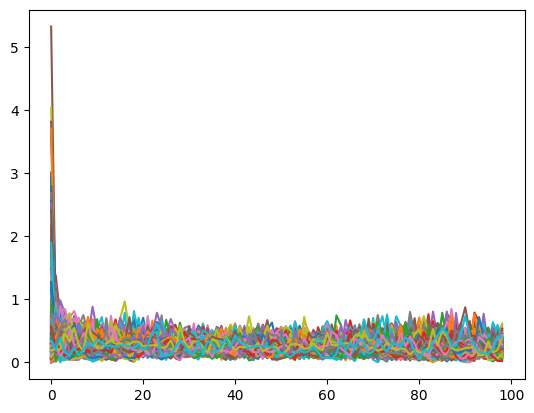

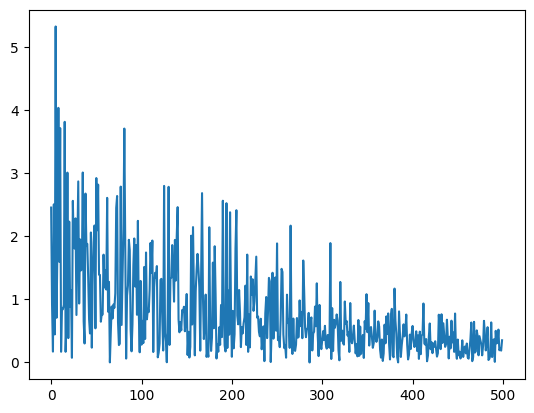

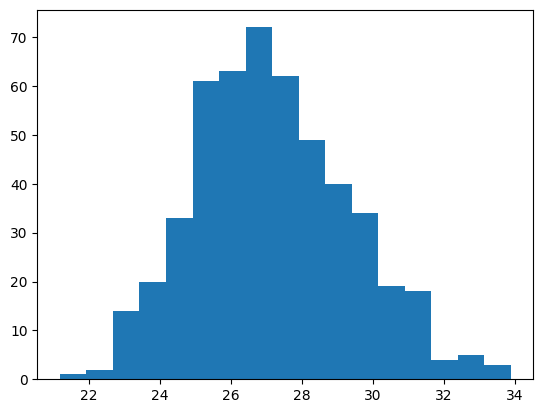

In [56]:
dist = getDistance(output)
print(dist.shape)

plt.plot(dist)
plt.show()

plt.plot(dist[0, :])
plt.show()

plt.hist(np.sum(dist, axis = 0), bins = 'auto')
plt.show()

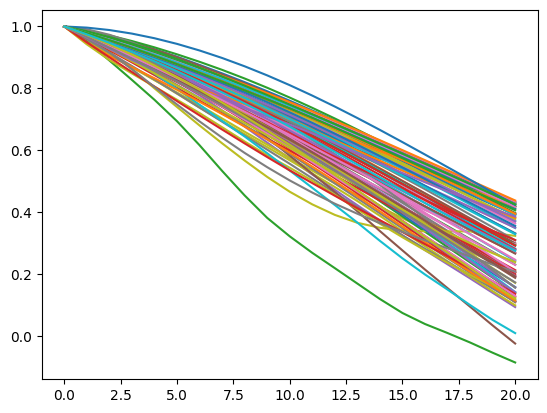

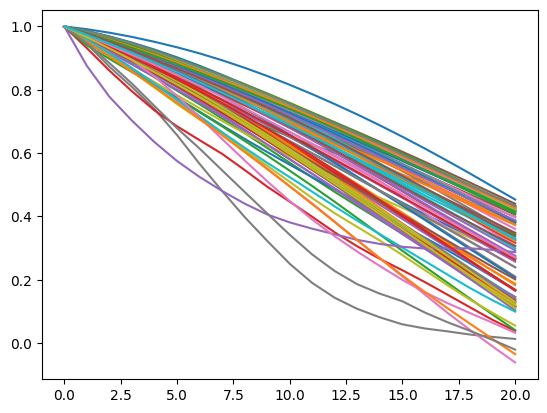

In [57]:
result = np.zeros((21, output.shape[1], 2))
for i in range(output.shape[1]):
    result[:, i, 0] = sm.tsa.acf(output[:,i, 0])
    result[:, i, 1] = sm.tsa.acf(output[:,i, 1])

for i in range(100):
    plt.plot(result[:, i, 0])

plt.show()


for i in range(100):
    plt.plot(result[:, i, 1])

plt.show()

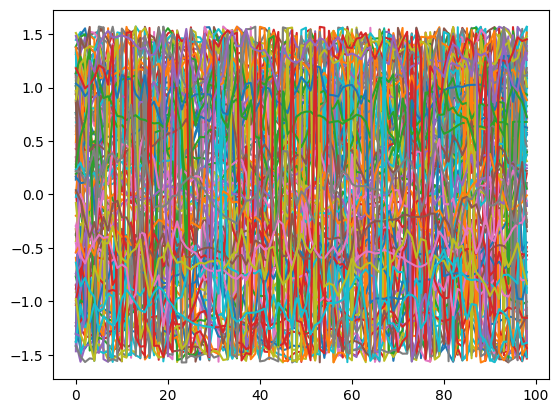

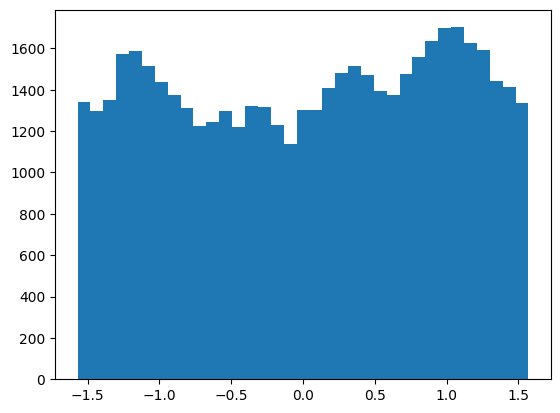

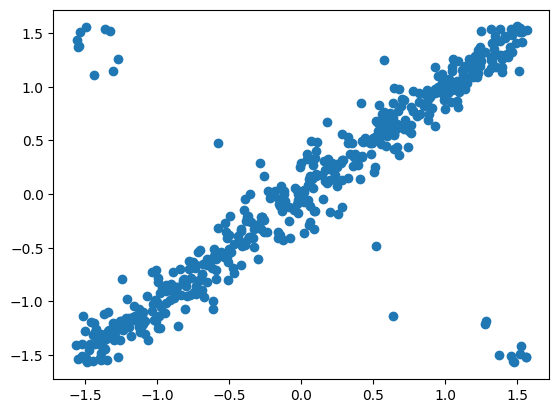

In [58]:
for i in range(100):
    plt.plot(angleSpeed[:, i])

plt.show()

plt.hist(angleSpeed.reshape(-1), bins = 'auto')
plt.show()

ind = 50
plt.scatter(angleSpeed[ind, :], angleSpeed[ind+1, :])
plt.show()

[[1.         0.78780571]
 [0.78780571 1.        ]]


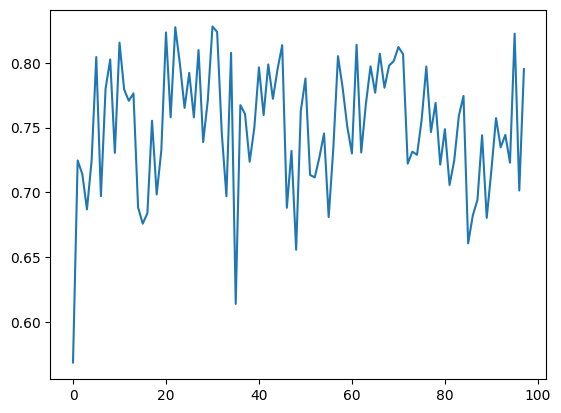

In [59]:
print(np.corrcoef(angleSpeed[ind, :], angleSpeed[ind+1, :]))            # add robustness to outliers --  same idea as cosine similarity


corrAngle = []

for i in range(angleSpeed.shape[0]-1):
    corrAngle.append(np.corrcoef(angleSpeed[i, :], angleSpeed[i+1, :])[0, 1])

plt.plot(corrAngle)
plt.show()
# more diversity at hte beginning (could also work with the vairance of gaussians)

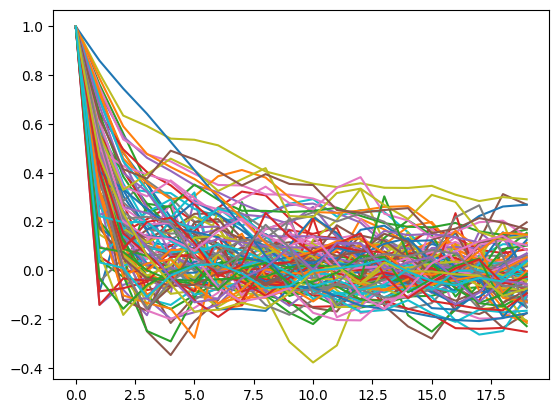

In [60]:
resultAngle = np.zeros((20, angleSpeed.shape[1]))
for i in range(output.shape[1]):
    resultAngle[:, i] = sm.tsa.acf(angleSpeed[:,i])

for i in range(100):
    plt.plot(resultAngle[:, i])

plt.show()

In [61]:
def euclidean_distance(point1, point2):
    return np.sum((point1 - point2) ** 2)

def findClosestNeighbors(pos, N = 5):

    closest_neighbors = []

    for i, position in enumerate(pos):
        distances = [euclidean_distance(position, other_position) for j, other_position in enumerate(pos) if i != j]
        
        closest_indices = np.argsort(distances)[:N]
        closest_neighbors.append([(j, pos[j]) for j in closest_indices])

    return closest_neighbors


## from https://www.kaggle.com/code/lucasmorin/dynamic-time-warping-performance-applications
def DTWDistance(s1, s2):
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


In [62]:
N = 10
closesN = findClosestNeighbors(output[0, :, :], N)
simVectX = []
simVectY = []


for i in tqdm(range(output.shape[0])):

    cN = closesN[i]
    valX = 0
    valY = 0
    for j in range(N):
        valX += DTWDistance(output[:, cN[j][0], 0], output[:, i, 0])
        valY += DTWDistance(output[:, cN[j][0], 1], output[:, i, 1])


    simVectX.append(valX)
    simVectY.append(valY)

100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


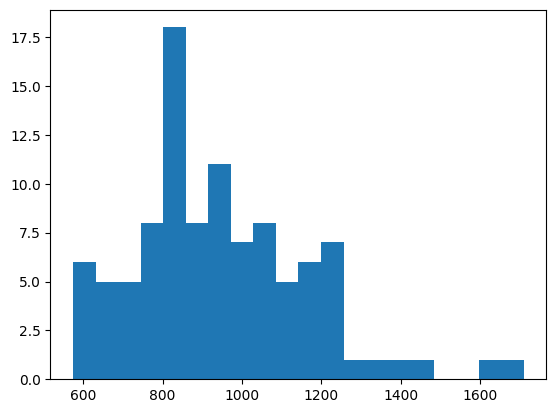

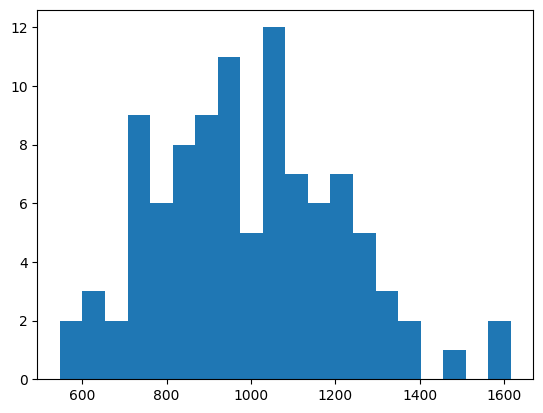

In [63]:
plt.hist(simVectX, bins = 20)
plt.show()

plt.hist(simVectY, bins = 20)
plt.show()

In [64]:
class distributionStats():
    def __init__(self, vect, d, info = None):
        self.statistics = {}
        self.info = info

        if 'mean' in d:
            self.statistics['mean'] = np.mean(vect, axis=0)
        
        if 'variance' in d:
            self.statistics['variance'] = np.var(vect, axis=0)

        if 'kurtosis' in d:
            self.statistics['kurtosis'] = stats.kurtosis(vect, fisher = False)      # check ficher definition and the other

        if 'skewness' in d:
            self.statistics['skewness'] = stats.skew(vect)

    def _addElement(self, name:str, value)->None:
        """
        Function to add an element to the statistics summary of some distribution
        to the summary

        Args:
        -----
        - `name`: name to add
        - `value`: associated value
        """

        if name not in self.statistics:
            self.statistics[name] = value